# Second round of FMR data

In [2]:
import numpy as np
import skrf as rf
import matplotlib.pyplot as plt
import glob
import os.path
from scipy.optimize import curve_fit

In [2]:
# function that receives a path to a folder (pathlike object) where FMR data (s1p format) is

def read_FMR (folder_path):
    # check if given folder is valid
    if (False == os.path.isdir(folder_path)):
        raise Exception("Sorry, the folder from where you want me to read the FMR data does not exit")
    
    if "/" != folder_path[-1]:
        folder_path += "/"
    
    # define the data structure as a dictionary with: key: string same as filename + value: dataframe containing FMR data
    FMR_data = {}
    file_list = glob.glob("*.s1p", root_dir=folder_path)

    for file in file_list:
        # the key is the file name (i have to remove path and extension)
        file_name = file[ : file.find(".s1p")]
        FMR_data[file_name] = rf.Network(folder_path + file).to_dataframe()

        # rename columns
        FMR_data[file_name] = FMR_data[file_name].reset_index().rename({"s_db 11": "Sparam", "index": "freq"}, axis='columns')

    return FMR_data

I will substract the background measurement or the highest field measurement from the data. It seems that it does not make much difference, so I think I will be ignoring this completely.

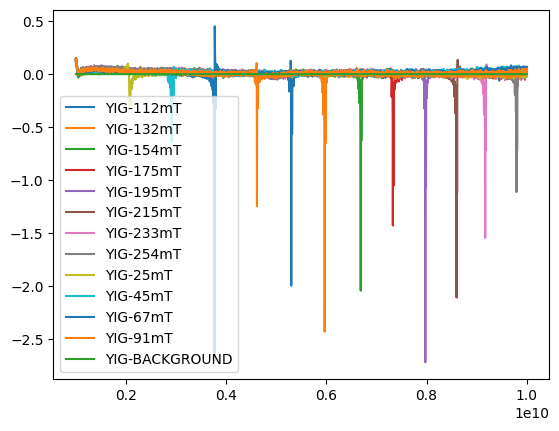

In [29]:
FMR_YIG = read_FMR("./FMR Data Alex/yig fmr")

high_field_background = FMR_YIG["YIG-BACKGROUND"]
highest_field_sweep = FMR_YIG["YIG-254mT"]

FMR_YIG_corrected = FMR_YIG.copy()

for freq_sweep in FMR_YIG:
    FMR_YIG_corrected[freq_sweep].Sparam = FMR_YIG_corrected[freq_sweep].Sparam - high_field_background.Sparam
    plt.plot(FMR_YIG_corrected[freq_sweep]["freq"], FMR_YIG_corrected[freq_sweep]["Sparam"], label=freq_sweep)

plt.legend()

Find the peak for each frequency sweep. Trim the dataset to around the peak.

In [ ]:
peak_idx_list = {}
peak_freq_list = {}

FMR_YIG_corrected = FMR_YIG.copy()

for freq_sweep in FMR_YIG:
    peak_idx = FMR_YIG[freq_sweep].Sparam.idxmin()
    peak_idx_list[freq_sweep] = peak_idx
    peak_freq_list[freq_sweep] = FMR_YIG[freq_sweep].freq.iloc[peak_idx]

    # trim data to a window of 0.6 GHz around the peak
    freq_window = 0.4 * 1e9       # in Hz
    FMR_YIG_corrected[freq_sweep] = FMR_YIG_corrected[freq_sweep][ (peak_freq_list[freq_sweep] - freq_window/2 < FMR_YIG_corrected[freq_sweep].freq)
                                                                  & (FMR_YIG_corrected[freq_sweep].freq < peak_freq_list[freq_sweep] + freq_window/2) ]


freq_sweep_name_to_plot = "YIG-25mT"

for freq_sweep_name_to_plot in FMR_YIG:
    freq_sweep_to_plot = FMR_YIG_corrected[freq_sweep_name_to_plot]
    # plot the frequency sweep
    fig, ax = plt.subplots()
    index_range = np.arange(len(freq_sweep_to_plot))
    ax.plot(freq_sweep_to_plot.freq, freq_sweep_to_plot.Sparam, label=freq_sweep_name_to_plot)
    # mark the peak
    #ax.scatter(peak_freq_list[freq_sweep_name_to_plot], freq_sweep_to_plot.Sparam.loc[peak_idx_list[freq_sweep_name_to_plot]], color="red")
    ax.legend()


Fit a Lorentzian to the peaks.

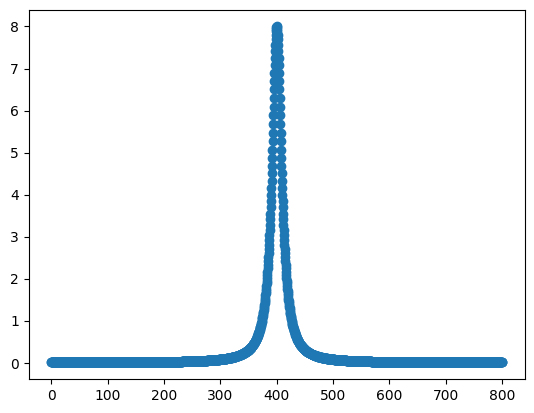

In [6]:
def lorentzian (x, res_freq, HWHM, peak):
    return peak / (((x-res_freq)/HWHM)**2 + 1)

freq_range = np.arange(0, 800, 0.4)
plt.scatter(freq_range, lorentzian(freq_range, 400, 10, 8))

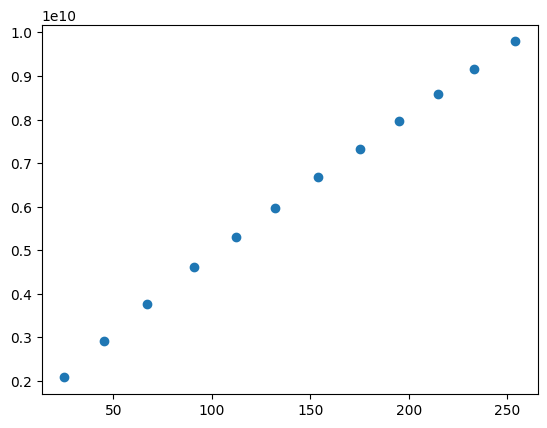

In [74]:
B_range = [int(dataset_name[dataset_name.find("-") + 1 : dataset_name.rfind("mT")]) for dataset_name in FMR_YIG if dataset_name != "YIG-BACKGROUND"]
plt.scatter(B_range, [peak_freq_list[dataset_name] for dataset_name in peak_freq_list if dataset_name != "YIG-BACKGROUND"])



The gyromagnetic ratio is: 2pi * 29.95 GHz/T.
The saturation magnetization 4pi*M_s is: 1681 G


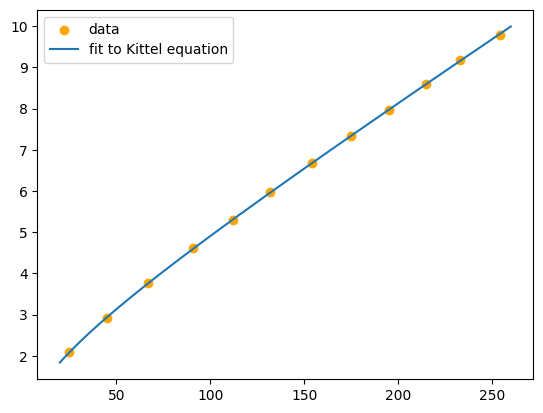

In [101]:
def thin_film_Kittel(x, g, M):
    return g * np.sqrt(x * (x + M))

B_range = np.sort([int(dataset_name[dataset_name.find("-") + 1 : dataset_name.rfind("mT")]) for dataset_name in FMR_YIG if dataset_name != "YIG-BACKGROUND"])
res_freq_list = np.sort([peak_freq_list[dataset_name] for dataset_name in peak_freq_list if dataset_name != "YIG-BACKGROUND"])

[gyromag_ratio, mu_M], pcov = curve_fit(f=thin_film_Kittel, xdata=B_range, ydata=res_freq_list, p0=[2*np.pi*1e9, 1e-4])

mu_0 = 4*np.pi*1e-7
M = mu_M / mu_0 *1e-3    # A/m
plt.scatter(B_range, res_freq_list * 1e-9, label="data", color="orange")

plt.plot(np.arange(20, 260, 0.1), thin_film_Kittel(np.arange(20, 260, 0.1), gyromag_ratio, mu_M)*1e-9, label="fit to Kittel equation")
plt.legend()
print(f"The gyromagnetic ratio is: 2pi * {gyromag_ratio*1e-6:.4g} GHz/T.")
print(f"The saturation magnetization 4pi*M_s is: {mu_M*10:.4g} G")